# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. Import Librairies

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import collections
from torch.autograd import Variable
from collections import namedtuple, deque
from itertools import count
import copy
import datetime
import time

### 5. Build the actor & critic Network

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)
    
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))
    
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128, dropout=0.2):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.dropout = nn.Dropout(p=dropout)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)    

### 6. Build the replay Buffer

In [8]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

### 7. Build the noise process

In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)
 
    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.randn() for i in range(len(x))])
        self.state = x + dx
        return self.state

### 8. Build the agent

In [32]:
class Agent:
    
    def __init__(self,action_space,state_space,num_agents,random_seed=0,device="cpu"):

        self.seed = random.seed(random_seed)
        self.memory_size = int(1e5)
        self.batch_size  = 256
        self.state_space = state_space
        self.action_space = action_space
        self.num_agents = num_agents
        self.gamma = 0.99
        self.lr_actor = 1e-4
        self.lr_critic = 1e-4
        self.tau = 1e-2
        self.device = device
        self.epsilon = 1.0
        self.epsilon_decay = 1e-6
        self.update_every  = 5
        self.num_updates = 10
        
        # Initialize actor network
        self.act_net     = Actor(state_space, action_space,random_seed).to(device)
        self.tgt_act_net = Actor(state_space, action_space,random_seed).to(device)
        self.act_opt     = optim.Adam(self.act_net.parameters(), lr=self.lr_actor)
        
        # initialize critique network
        self.crt_net     = Critic(state_space, action_space,random_seed).to(device)
        self.tgt_crt_net = Critic(state_space, action_space,random_seed).to(device)
        self.crt_opt     = optim.Adam(self.crt_net.parameters(), lr=self.lr_critic)
        
        # noise process
        self.noise = OUNoise(action_space, random_seed)
    
        # Replay memory
        self.memory = ReplayBuffer(self.memory_size, self.batch_size, random_seed)

        # Make sure target is with the same weight as the source
        self.hard_copy(self.tgt_act_net, self.act_net)
        self.hard_copy(self.tgt_crt_net, self.crt_net)

    def reset(self):
        self.noise.reset()
    
    def soft_update(self, local_model, target_model,tau):
      
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data) 

    def hard_copy(self, local_model, target_model):
      
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data) 
    
    def step(self, states, actions, rewards, next_states, dones,t_step):
        
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        if len(self.memory) > self.batch_size and t_step % self.update_every == 0 :
            for _ in range(self.num_updates):
                experiences = self.memory.sample() # sample from the experience replay
                self.learn(experiences) # learn from the experience replay
           
        
        #  Noise update
        self.epsilon -= self.epsilon_decay
        
        
    def act(self,state,add_noise=True):
        state = torch.from_numpy(state).float().to(self.device)
        self.act_net.eval()
        with torch.no_grad():
            actions = self.act_net(state).cpu().data.numpy()
        self.act_net.train()
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions,-1,1)  
    
    def learn(self, experiences):
        
        # sample from our experience replay buffer
        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = experiences

        
        # get next action and Q values 
        action_next         = self.tgt_act_net(batch_next_states)
        q_target_next       = self.tgt_crt_net(batch_next_states,action_next)
        
        # get q-targets and q-expected
        q_targets   = batch_rewards + (self.gamma * q_target_next * (1 - batch_dones))
        q_expected = self.crt_net(batch_states,batch_actions)
        

        # ------------------- update critic ---------------------------- #
        critic_loss = F.mse_loss(q_expected, q_targets) 
        self.crt_opt.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.crt_net.parameters(), 1)
        self.crt_opt.step()

        # ------------------- update actor ---------------------------- #
        action_pred = self.act_net(batch_states)
        actor_loss = - self.crt_net(batch_states,action_pred).mean()
        self.act_opt.zero_grad()
        actor_loss.backward()
        self.act_opt.step()      
        
        
         # ------------------- update target network ------------------- #
        self.soft_update(self.act_net, self.tgt_act_net,self.tau) 
        self.soft_update(self.crt_net, self.tgt_crt_net,self.tau)

### 9. Build the training function

In [33]:
def ddpg(agent,n_episodes=1000,max_t=1000,random_seed=15):
    scores_window = deque(maxlen=100)  # last 100 scores
    global_scores     = []
    global_average_score = []
    tic = time.time()
    solved = False
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations 
        agent.reset()
        scores = np.zeros(num_agents) 
        timestep = time.time()
        
        for t in range(max_t):
            actions     = agent.act(states)
            env_info    = env.step(actions)[brain_name]         # send the action to the environment
            next_states = env_info.vector_observations          # get the next state
            rewards     = env_info.rewards                      # get the reward
            dones       = env_info.local_done                   # see if episode has finished
            
            agent.step(states, actions, rewards, next_states, dones,t)
            states = next_states
            scores += rewards
            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        scores_window.append(np.max(scores))
        global_scores.append(np.max(scores))
        score_average = np.mean(scores_window)
        global_average_score.append(score_average)

        
        if i_episode % 50 == 0:
            torch.save(agent.act_net.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.crt_net.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score_average))   
        
        if not solved and score_average >= 0.5:
            solved = True
            toc = time.time()
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}, training time: {}'.format(i_episode, score_average, toc-tic))
            torch.save(agent.act_net.state_dict(), 'best_checkpoint_actor.pth')
            torch.save(agent.crt_net.state_dict(), 'best_checkpoint_critic.pth')
            
    return global_scores, global_average_score

### 10. Train the Agent

In [31]:
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]
num_agents = len(env_info.agents)
device = "cpu"
agent = Agent(action_size,state_size,num_agents,random_seed=0)
global_scores, global_average_score = ddpg(agent)

Episode 50	Average Score: 0.00
Episode 100	Average Score: 0.00
Episode 150	Average Score: 0.01
Episode 200	Average Score: 0.02
Episode 250	Average Score: 0.05
Episode 300	Average Score: 0.08
Episode 350	Average Score: 0.11
Episode 400	Average Score: 0.13
Episode 450	Average Score: 0.13
Episode 500	Average Score: 0.14
Episode 550	Average Score: 0.17
Episode 600	Average Score: 0.17
Episode 650	Average Score: 0.20
Episode 700	Average Score: 0.28
Episode 750	Average Score: 0.36
Episode 800	Average Score: 0.36
Episode 850	Average Score: 0.38

Environment solved in 895 episodes!	Average Score: 0.51, training time: 3271.125985145569
Episode 900	Average Score: 0.52
Episode 950	Average Score: 0.55
Episode 1000	Average Score: 0.57


### 11. Display results

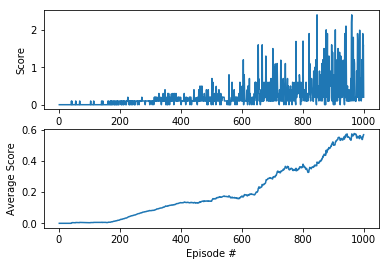

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, len(global_scores)+1), global_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, len(global_average_score)+1), global_average_score)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

### 12. Test the Agent

In [41]:
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]
device = "cpu"

# Load Agent
num_agents = len(env_info.agents)
agent = Agent(action_size,state_size,num_agents,random_seed=0)
agent.act_net.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.crt_net.load_state_dict(torch.load('checkpoint_critic.pth'))            
scores_window = []
for i_episode in range(10):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states) # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    scores_window.append(np.max(scores))
    
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores_window)))

Total score (averaged over agents) this episode: 0.8190000122413039


In [ ]:
env.close()